<a href="https://colab.research.google.com/github/Trading-com-Dados/desenvolvimento_interno/blob/main/20220330_Ciclos_de_Mercado_sazonalidade_anual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://tradingcomdados.com/images/logotipo/logotipo-trading-com-dados.svg" width="300">

---
# **Ciclos de Mercado: avaliando a sazonalidade anual do IBOV**
---

## **Contexto:**

Você provavelmente já ouviu a expressão "*Sell in May and go away!*", que em uma tradução literal seria algo como "*Venda em maio e vá embora!*". O fato é que além de uma rima legal, essa expressão traz um contexto de sazonalidade de mercado muito interessante e que, sem dúvida, merece nossa atenção.<p>
Estudos mostram que a expressão original é ainda mais curiosa: "*Sell in May, go away, and come back on St. Leger’s Day*" = Venda em maio, vá embora e volte no dia de 'Saint Leger' (15 de setembro). A estratégia envolve o lucro a partir na sazonalindade anual do mercado. Basicamente, você venderia todas as suas ações em maio, quando o mercado historicamente apresenta um desempenho abaixo do esperado. No mesmo ano, entre outubro e novembro, você os compra novamente, quando o mercado de ações começa a subir novamente.<p>
Em um artigo intitulado "*The Halloween Indicator, 'Sell in May and Go Away': Another Puzzle*", publicado na American Economic Review (2002), os autores Jacobsen and Bouman avaliam e documentam esse padrão para 36 de 37 mercados avaliados (incluindo países desenvolvidos e emergentes). Eles reportam que esse "indicador Halloween" é particularmente forte na Europa, e surpreendentemente pode ser observado desde 1694 no mercado do UK:<p>
>[...] we find this inherited wisdom to be true in 36 of the 37 developed and emerging markets studied in our sample. The Sell in May effect tends to be particularly strong in European countries and is robust over time. Sample evidence, for instance, shows that in the UK the effect has been noticeable since 1694.

Por fim, embora tenham testado diversos preditores que pudessem explicar esse padrão, não chegaram a nenhuma conclusão sobre o que poderia de fato explicar esse "quebra-cabeça":
>[...] While we have examined a number of possible explanations, none of these appears to convincingly explain the puzzle.

Nós, da Trading com Dados, apresentamos aqui um código exemplificando o padrão no IBOV. E em seus ativos preferidos, quer testar?

# 1. Bibliotecas utilizadas

In [1]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 19.9 MB/s 
     |████████████████████████████████| 63 kB 1.5 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.express as px
import seaborn as sns

# 2. Obtenção e organização do conjunto de dados para o estudo

### 2.1. Extração dos dados e criação de variáveis úteis

Neste código iremos explorar apenas os resultados mensais para fins de simplificar a quantidade de dados e os resultados.

In [3]:
# Cotações mensais do IBOV cobrindo o máximo de tempo possível, incluindo as últimas cotações do mês atual

OHLC_IBOV = yf.download('^BVSP',period='max',interval='1mo')

[*********************100%***********************]  1 of 1 completed


In [4]:
# Podemos notar que os primeiros dados acessados são de maio/1993

OHLC_IBOV

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-05-01,24.100000,35.599998,23.799999,34.900002,34.900002,0
1993-06-01,35.400002,54.799999,35.400002,53.700001,53.700001,0
1993-07-01,53.700001,67.400002,51.700001,65.599998,65.599998,0
1993-08-01,65.599998,100.099998,60.599998,96.400002,96.400002,0
1993-09-01,96.400002,150.300003,96.400002,146.600006,146.600006,0
...,...,...,...,...,...,...
2021-12-01,101916.000000,109493.000000,100727.000000,104822.000000,104822.000000,234055900
2022-01-01,104823.000000,113057.000000,100850.000000,112388.000000,112388.000000,245216600
2022-02-01,112143.000000,115734.000000,109125.000000,113142.000000,113142.000000,224030100


Observamos os 4 parametros típicos das cotações OHLC, assim como Adj Close e Volume <p>
No caso do IBOV, o Adj Close não faz sentido já que é o mesmo valor do Close (o que seria diferente se estivessemos falando de algum papel específico do IBOV) <p>
Vamos aproveitar e calcular o parâmetro **Percent Change** que já exploramos em outros códigos<p>
Considerando o nosso estudo, o Percent Change pode ser avaliado como um resultado para aquele mês, já que é calculado da seguinte forma:

$$\frac{Close_{atual} - Close_{anterior}}{Close_{anterior}} \times  100 $$

Usaremos a função pct_change do pandas que retorna o resultado da mesma fórmula acima, porém sem multiplicar por 100.<p>
Isso mesmo, chama-se percent change mas não é expresso em % <p>
Criaremos a coluna 'Resultado_mes' multiplicando o resultado por 100 para termos o resultado em % como estamos acostumados (ao menos aqui no Brasil)

In [5]:
OHLC_IBOV['Resultado_mes'] = OHLC_IBOV['Close'].pct_change()*100
OHLC_IBOV

,Open,High,Low,Close,Adj Close,Volume,Resultado_mes
Date,,,,,,,
1993-05-01,24.100000,35.599998,23.799999,34.900002,34.900002,0,NaN
1993-06-01,35.400002,54.799999,35.400002,53.700001,53.700001,0,53.868190
1993-07-01,53.700001,67.400002,51.700001,65.599998,65.599998,0,22.160144
1993-08-01,65.599998,100.099998,60.599998,96.400002,96.400002,0,46.951225
1993-09-01,96.400002,150.300003,96.400002,146.600006,146.600006,0,52.074693
...,...,...,...,...,...,...,...
2021-12-01,101916.000000,109493.000000,100727.000000,104822.000000,104822.000000,234055900,2.852377
2022-01-01,104823.000000,113057.000000,100850.000000,112388.000000,112388.000000,245216600,7.217950
2022-02-01,112143.000000,115734.000000,109125.000000,113142.000000,113142.000000,224030100,0.670890


In [6]:
# Para fins didáticos, vamos excluir todas as cotações antes de janeiro de 1994 e também do ano atual (2022).
# Assim, temos um conjunto de dados é composto por cotações mensais ao longo de 28 anos, totalizando 336 meses

dataset_IBOV = OHLC_IBOV.loc['1994-01-01':'2021-12-31']
dataset_IBOV

,Open,High,Low,Close,Adj Close,Volume,Resultado_mes
Date,,,,,,,
1994-01-01,375.500000,741.700012,373.399994,740.599976,740.599976,0,97.230353
1994-02-01,740.599976,1116.000000,740.599976,1053.900024,1053.900024,0,42.303546
1994-03-01,1053.900024,1542.199951,1013.799988,1515.599976,1515.599976,0,43.808705
1994-04-01,1515.599976,1732.599976,1280.199951,1708.400024,1708.400024,0,12.721038
1994-05-01,1708.400024,2516.899902,1325.500000,2467.199951,2467.199951,0,44.415823
...,...,...,...,...,...,...,...
2021-08-01,121803.000000,124536.000000,114801.000000,118781.000000,118781.000000,201788600,-2.479454
2021-09-01,118793.000000,119942.000000,107520.000000,110979.000000,110979.000000,231540400,-6.568391
2021-10-01,110980.000000,114927.000000,102854.000000,103501.000000,103501.000000,243860400,-6.738212


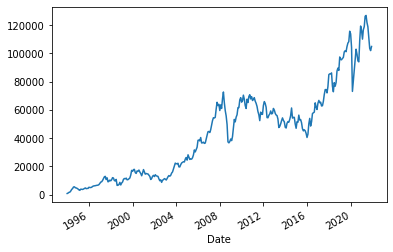

In [7]:
# Uma rápida visualização do preço de fechamento em nosso dataset

dataset_IBOV['Close'].plot()

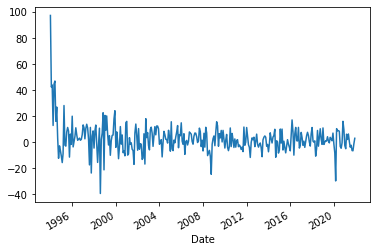

In [8]:
# E agora dos resultados percent change

dataset_IBOV['Resultado_mes'].plot()

Na figura acima, observamos que nos primeiros anos temos uma grande variação nos resultados ('ganhos' e 'perdas' em % que superam até a crise de 2008 e COVID-19) <p>
Nessas horas um bom pesquisador precisa fazer decisões importantes <p>
Por exemplo, veja nos outputs acima que, em 1994, os meses de jan, fev e mar apresentaram resultados de 97%, 42% e 44%, respectivamente<p>
Será que este tipo de resultado ajudaria a entender o padrão que queremos testar ou apenas produzir um ruído que atrapalhe as estatísticas?<p>
Existem diversas técnicas que poderíamos usar para decidir sobre a melhor forma de filtragem dos dados. Para simplificar, vamos utilizar os dados a partir de 2000, que parecem já apresentar variações mais dentro do padrão das que observamos até hoje

In [9]:
# Filtrar a partir de 2000. Nosso conjunto de dados então compreende 22 anos (2000 a 2021), totalizando 264 meses

dataset_IBOV = dataset_IBOV.loc['2000-01-01':'2021-12-31']
dataset_IBOV

,Open,High,Low,Close,Adj Close,Volume,Resultado_mes
Date,,,,,,,
2000-01-01,17098.0,18099.0,15350.0,16388.0,16388.0,0,-4.118886
2000-02-01,16389.0,18886.0,16389.0,17660.0,17660.0,0,7.761777
2000-03-01,17668.0,19047.0,16922.0,17820.0,17820.0,0,0.906002
2000-04-01,17826.0,17826.0,14029.0,15538.0,15538.0,0,-12.805836
2000-05-01,15596.0,15944.0,13556.0,14957.0,14957.0,0,-3.739220
...,...,...,...,...,...,...,...
2021-08-01,121803.0,124536.0,114801.0,118781.0,118781.0,201788600,-2.479454
2021-09-01,118793.0,119942.0,107520.0,110979.0,110979.0,231540400,-6.568391
2021-10-01,110980.0,114927.0,102854.0,103501.0,103501.0,243860400,-6.738212


In [10]:
# Checar a ocorrência de NAs é um passo fundamental durante a organização de qq conjunto de dados
# Uma das formas pode ser usando o .isna

dataset_IBOV.isna().sum()

Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
Resultado_mes    0
dtype: int64

In [11]:
# Como a análise envolve os meses (nossa unidade amostral) vamos criar algumas outras colunas no nosso dataframe
# Primeiro calcular uma coluna que indique o mês do ano usando um método da biblioteca pandas e um método que transforma a data em strings desejadas (ex., mês, dia da semana...)
# Aproveitar e colocar uma para o ano e o mês também como numérico (para alguma análise de classificação posterior, já que a alfabetica não faria sentido)

dataset_IBOV["Mes"] = pd.to_datetime(dataset_IBOV.index).strftime('%B')
dataset_IBOV["Ano"] = pd.to_datetime(dataset_IBOV.index).strftime('%Y')
dataset_IBOV["Mes_num"] = pd.to_datetime(dataset_IBOV.index).strftime('%m')
dataset_IBOV

# Nesse caso, não se preocupe com a msg do output. Elas não são erros, mas advertências sobre o uso do índice do df (nesse caso, nossas datas)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,Open,High,Low,Close,Adj Close,Volume,Resultado_mes,Mes,Ano,Mes_num
Date,,,,,,,,,,
2000-01-01,17098.0,18099.0,15350.0,16388.0,16388.0,0,-4.118886,January,2000,01
2000-02-01,16389.0,18886.0,16389.0,17660.0,17660.0,0,7.761777,February,2000,02
2000-03-01,17668.0,19047.0,16922.0,17820.0,17820.0,0,0.906002,March,2000,03
2000-04-01,17826.0,17826.0,14029.0,15538.0,15538.0,0,-12.805836,April,2000,04
2000-05-01,15596.0,15944.0,13556.0,14957.0,14957.0,0,-3.739220,May,2000,05
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,121803.0,124536.0,114801.0,118781.0,118781.0,201788600,-2.479454,August,2021,08
2021-09-01,118793.0,119942.0,107520.0,110979.0,110979.0,231540400,-6.568391,September,2021,09
2021-10-01,110980.0,114927.0,102854.0,103501.0,103501.0,243860400,-6.738212,October,2021,10


In [12]:
# Por fim, deixar apenas 2 casas decimais para o resultado mensal

dataset_IBOV['Resultado_mes'] = round(dataset_IBOV['Resultado_mes'],2)
dataset_IBOV

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Open,High,Low,Close,Adj Close,Volume,Resultado_mes,Mes,Ano,Mes_num
Date,,,,,,,,,,
2000-01-01,17098.0,18099.0,15350.0,16388.0,16388.0,0,-4.12,January,2000,01
2000-02-01,16389.0,18886.0,16389.0,17660.0,17660.0,0,7.76,February,2000,02
2000-03-01,17668.0,19047.0,16922.0,17820.0,17820.0,0,0.91,March,2000,03
2000-04-01,17826.0,17826.0,14029.0,15538.0,15538.0,0,-12.81,April,2000,04
2000-05-01,15596.0,15944.0,13556.0,14957.0,14957.0,0,-3.74,May,2000,05
...,...,...,...,...,...,...,...,...,...,...
2021-08-01,121803.0,124536.0,114801.0,118781.0,118781.0,201788600,-2.48,August,2021,08
2021-09-01,118793.0,119942.0,107520.0,110979.0,110979.0,231540400,-6.57,September,2021,09
2021-10-01,110980.0,114927.0,102854.0,103501.0,103501.0,243860400,-6.74,October,2021,10


### 3.2. Corrigindo um problema pontual nos dados

Se você for observador e estiver acostumado com dataframes, talvez já conseguiu notar que o mes de novembro na penultima linha não aparece.<p>
Temos 2 outubros, sendo que o segundo (penultima linha) está indicado como 31/out<p>
Pelo que parece, está relacionado apenas ao parâmetro *interval=1mo* para o IBOV na yfinance

In [13]:
# Agora uma tabela dinâmica (pivot table), podemos ver se isso acontece em outros meses
# Aplicamos uma contagem de células por meses

pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Mes"], columns=[],aggfunc='count')

,Resultado_mes
Mes,
April,22
August,22
December,22
February,22
January,22
July,22
June,22
March,22
May,22


In [14]:
# Vemos que esse erro parece ocorrer em 4 anos
# Explorando um poouco mais

pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Ano"], columns=["Mes_num"],aggfunc='count')

# De fato, ocorreu de 2018 a 2021

Mes_num,01,02,03,04,05,06,07,08,09,10,11,12
Ano,,,,,,,,,,,,
2000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2001,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2002,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2003,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2004,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2005,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2006,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2007,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2008,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Para não deixar tudo muito extenso, fizemos uma checagem com diversas outras fontes de dados de cotações. Trata-se de um erro de data, sendo que os valores estão corretos. A data '2021-10-31' deveria ser '2021-11-01' para todos os 4 anos<p>
Vamos então apenas substituir as 4 datas já que os valores OHLC estão iguais aos relacionados ao mes de novembro em outras fontes

In [15]:
# Como dito, fazer de forma rápida, em uma única célula de código, para não ficar mt extenso e fugirmos do nosso objetivo que é testar a hipótese do "Indicador de Halloween"

dataset_IBOV['Data'] = pd.to_datetime(dataset_IBOV.index)
dataset_IBOV = dataset_IBOV.replace('2021-10-31','2021-11-01')
dataset_IBOV = dataset_IBOV.replace('2020-10-31','2020-11-01')
dataset_IBOV = dataset_IBOV.replace('2019-10-31','2019-11-01')
dataset_IBOV = dataset_IBOV.replace('2018-10-31','2018-11-01')
dataset_IBOV

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Open,High,Low,Close,Adj Close,Volume,Resultado_mes,Mes,Ano,Mes_num,Data
Date,,,,,,,,,,,
2000-01-01,17098.0,18099.0,15350.0,16388.0,16388.0,0,-4.12,January,2000,01,2000-01-01
2000-02-01,16389.0,18886.0,16389.0,17660.0,17660.0,0,7.76,February,2000,02,2000-02-01
2000-03-01,17668.0,19047.0,16922.0,17820.0,17820.0,0,0.91,March,2000,03,2000-03-01
2000-04-01,17826.0,17826.0,14029.0,15538.0,15538.0,0,-12.81,April,2000,04,2000-04-01
2000-05-01,15596.0,15944.0,13556.0,14957.0,14957.0,0,-3.74,May,2000,05,2000-05-01
...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,121803.0,124536.0,114801.0,118781.0,118781.0,201788600,-2.48,August,2021,08,2021-08-01
2021-09-01,118793.0,119942.0,107520.0,110979.0,110979.0,231540400,-6.57,September,2021,09,2021-09-01
2021-10-01,110980.0,114927.0,102854.0,103501.0,103501.0,243860400,-6.74,October,2021,10,2021-10-01


In [16]:
# Criamos uma estrutura de repetição que preencherá as listas (inicialmente vazias) com o mes referente à coluna Data que foi corrigida

Mes = []
Mes_num = []

for i in range(0,len(dataset_IBOV.index)):
  mes_linha = dataset_IBOV['Data'][i].strftime('%B')
  mes_num_linha = dataset_IBOV['Data'][i].strftime('%m')
  Mes.append(mes_linha)
  Mes_num.append(mes_num_linha)

In [17]:
# Nesse caso deixaremos Mes final para comparar (apenas visualizaçao, poderia já substituir direto, como faremos com Mes_num)

dataset_IBOV['Mes_final'] = Mes
dataset_IBOV['Mes_num'] = Mes_num
dataset_IBOV

,Open,High,Low,Close,Adj Close,Volume,Resultado_mes,Mes,Ano,Mes_num,Data,Mes_final
Date,,,,,,,,,,,,
2000-01-01,17098.0,18099.0,15350.0,16388.0,16388.0,0,-4.12,January,2000,01,2000-01-01,January
2000-02-01,16389.0,18886.0,16389.0,17660.0,17660.0,0,7.76,February,2000,02,2000-02-01,February
2000-03-01,17668.0,19047.0,16922.0,17820.0,17820.0,0,0.91,March,2000,03,2000-03-01,March
2000-04-01,17826.0,17826.0,14029.0,15538.0,15538.0,0,-12.81,April,2000,04,2000-04-01,April
2000-05-01,15596.0,15944.0,13556.0,14957.0,14957.0,0,-3.74,May,2000,05,2000-05-01,May
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,121803.0,124536.0,114801.0,118781.0,118781.0,201788600,-2.48,August,2021,08,2021-08-01,August
2021-09-01,118793.0,119942.0,107520.0,110979.0,110979.0,231540400,-6.57,September,2021,09,2021-09-01,September
2021-10-01,110980.0,114927.0,102854.0,103501.0,103501.0,243860400,-6.74,October,2021,10,2021-10-01,October


In [18]:
#Agora sim, temos o dataset pronto para explorarmos as nossos padrões de ciclos de mercado

pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Ano"], columns=["Mes_num"],aggfunc='count')

Mes_num,01,02,03,04,05,06,07,08,09,10,11,12
Ano,,,,,,,,,,,,
2000,1,1,1,1,1,1,1,1,1,1,1,1
2001,1,1,1,1,1,1,1,1,1,1,1,1
2002,1,1,1,1,1,1,1,1,1,1,1,1
2003,1,1,1,1,1,1,1,1,1,1,1,1
2004,1,1,1,1,1,1,1,1,1,1,1,1
2005,1,1,1,1,1,1,1,1,1,1,1,1
2006,1,1,1,1,1,1,1,1,1,1,1,1
2007,1,1,1,1,1,1,1,1,1,1,1,1
2008,1,1,1,1,1,1,1,1,1,1,1,1


# 3. Análises para testar o padrão do **Indicador de Halloween**

### 3.1. Médias e Medianas mensais

A primeira grande pergunta que nos vêm à cabeça poderia ser:

**Qual a média de resultado de cada mês ao longo desses 22 anos?**

In [19]:
# Faremos uma tabela dinâmica (pivot table) para calcular a média de resultado por mês do ano
# Primeiro vamos definir a opção de apresentar numeros com 2 casas decimais

resultado_geral = pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Mes_num"], columns=[],aggfunc=np.mean)
round(resultado_geral,2)

,Resultado_mes
Mes_num,
01,0.53
02,1.19
03,-0.08
04,2.04
05,-1.10
06,-0.30
07,1.56
08,0.91
09,-0.87


In [20]:
# Vamos deixar as coisas um pouco mais visuais nesse resultado
# Formatação condicional (positivo verde, se 0 ou negativo vermelho)

resultado_geral.style.format('{:.2f}', na_rep="").applymap(lambda x: 'background-color : #e6ffe6' if x>0 else 'background-color : #ffe6e6')

,Resultado_mes
Mes_num,
01,0.53
02,1.19
03,-0.08
04,2.04
05,-1.10
06,-0.30
07,1.56
08,0.91
09,-0.87


Relembrando: "Sell in May, go away, and come back on St. Leger’s Day" = <u> Venda em maio, vá embora e volte no dia de 'Saint Leger' (15 de setembro)</u>

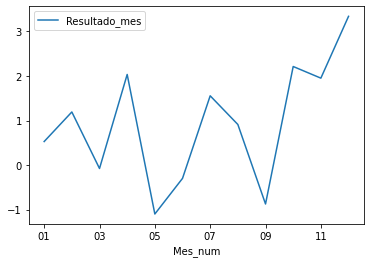

In [21]:
# Pelo menos a priori, o Indicador Halloween parece ser marcante para o IBOV
# Veja que maio tem a menor média de resultado e os meses pós setembro as maiores altas
# Vamos visualizar para facilitar

medias_mensais = pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Mes_num"], columns=[],aggfunc=np.mean)
medias_mensais.plot()

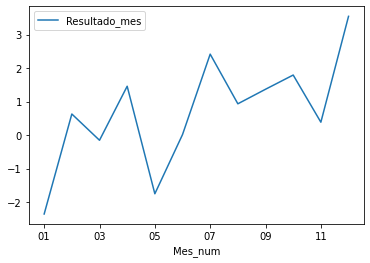

In [22]:
# A média pode "mascarar" alguns resultados quando a distribuição não é normal. O uso da mediana ao invés da média pode ser uma alternativa para evitar o efeito dos 'outliers'
# Usando a mediana, obtivemos um padrão gráfico semelhante, porém com algumas diferenças que são importantes em nossas análises
# 1. Veja que janeiro passa a ser o mês com menor mediana
# 2. Novembro não seria um mês tão bom quanto no grafico usando médias
# 3. Set não seria tão ruim como no grafico usando médias
 
medianas_mensais = pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Mes_num"], columns=[],aggfunc=np.median)
medianas_mensais.plot()

### 3.2. Médias, medianas e somatório de resultados mensais ao longo de todo o período avaliado

In [23]:
# Novamente, usando uma tabela dinâmica, porém com duas categorias de agrupamento: Ano em linhas e Mês em colunas
# Nesse caso, o parametro usado no argumento aggfunc não importa já que é um valor apenas (poderia ser media, mediana, max...)

result_mensais = pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Ano",], columns=["Mes_num"],aggfunc=np.mean)
result_mensais

Mes_num,01,02,03,04,05,06,07,08,09,10,11,12
Ano,,,,,,,,,,,,
2000,-4.12,7.76,0.91,-12.81,-3.74,11.84,-1.63,5.42,-8.18,-6.66,-10.63,14.84
2001,15.82,-10.08,-9.14,3.32,-1.80,-0.61,-5.54,-6.64,-17.17,6.85,13.79,5.00
2002,-6.31,10.31,-5.54,-1.28,-1.71,-13.39,-12.35,6.34,-16.94,17.92,3.35,7.22
2003,-2.90,-6.03,9.66,11.38,6.89,-3.35,4.62,11.80,5.52,12.31,12.25,10.17
2004,-1.73,-0.44,1.78,-11.45,-0.32,8.21,5.62,2.09,1.94,-0.83,9.01,4.25
2005,-7.04,15.56,-5.43,-6.64,1.46,-0.62,3.96,7.69,12.62,-4.40,5.71,4.82
2006,14.73,0.59,-1.70,6.35,-9.50,0.28,1.22,-2.28,0.60,7.72,6.80,6.06
2007,0.38,-1.68,4.36,6.88,6.77,4.06,-0.38,0.84,10.67,8.03,-3.54,1.40
2008,-6.88,6.72,-3.97,11.32,6.96,-10.43,-8.48,-6.43,-11.03,-24.80,-1.77,2.61


In [24]:
# Um pouco de cor para facilitar
# Nota algum mes com destaque positivo/negativo?

result_mensais.style.format('{:.2f}', na_rep="").applymap(lambda x: 'background-color : #e6ffe6' if x>0 else 'background-color : #ffe6e6')

Mes_num,01,02,03,04,05,06,07,08,09,10,11,12
Ano,,,,,,,,,,,,
2000,-4.12,7.76,0.91,-12.81,-3.74,11.84,-1.63,5.42,-8.18,-6.66,-10.63,14.84
2001,15.82,-10.08,-9.14,3.32,-1.80,-0.61,-5.54,-6.64,-17.17,6.85,13.79,5.00
2002,-6.31,10.31,-5.54,-1.28,-1.71,-13.39,-12.35,6.34,-16.94,17.92,3.35,7.22
2003,-2.90,-6.03,9.66,11.38,6.89,-3.35,4.62,11.80,5.52,12.31,12.25,10.17
2004,-1.73,-0.44,1.78,-11.45,-0.32,8.21,5.62,2.09,1.94,-0.83,9.01,4.25
2005,-7.04,15.56,-5.43,-6.64,1.46,-0.62,3.96,7.69,12.62,-4.40,5.71,4.82
2006,14.73,0.59,-1.70,6.35,-9.50,0.28,1.22,-2.28,0.60,7.72,6.80,6.06
2007,0.38,-1.68,4.36,6.88,6.77,4.06,-0.38,0.84,10.67,8.03,-3.54,1.40
2008,-6.88,6.72,-3.97,11.32,6.96,-10.43,-8.48,-6.43,-11.03,-24.80,-1.77,2.61


In [25]:
# Visualização gráfica por boxplots
# Lembrando que os boxplots trazem médias não paramétricas (mediana, quartis, amplitude...)

fig = px.box(dataset_IBOV, x="Mes_num", y="Resultado_mes")
fig.add_hline(y=0)
fig.show()

In [45]:
# Produzir uma tabela mais completa: números de meses avaliados, média, mediana, máx e mín

Tabela_01 = pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Mes_num"], aggfunc=['count',np.mean,np.median,np.max,np.min])
Tabela_01

,count,mean,median,amax,amin
,Resultado_mes,Resultado_mes,Resultado_mes,Resultado_mes,Resultado_mes
Mes_num,,,,,
01,22,0.529091,-2.360,15.82,-7.51
02,22,1.192727,0.630,15.56,-10.08
03,22,-0.076364,-0.155,16.97,-29.90
04,22,2.035000,1.460,15.55,-12.81
05,22,-1.098182,-1.755,12.49,-11.86
06,22,-0.298182,0.015,11.84,-13.39
07,22,1.555909,2.420,11.22,-12.35
08,22,0.911818,0.935,11.80,-8.33


In [46]:
# Podemos remover o índice 1 das colunas (Resultado_mes) que é desnecessário
# Assim, transformamos um multi index de colunas para index de colunas

Tabela_01.columns = Tabela_01.columns.droplevel(1)
Tabela_01

,count,mean,median,amax,amin
Mes_num,,,,,
01,22,0.529091,-2.360,15.82,-7.51
02,22,1.192727,0.630,15.56,-10.08
03,22,-0.076364,-0.155,16.97,-29.90
04,22,2.035000,1.460,15.55,-12.81
05,22,-1.098182,-1.755,12.49,-11.86
06,22,-0.298182,0.015,11.84,-13.39
07,22,1.555909,2.420,11.22,-12.35
08,22,0.911818,0.935,11.80,-8.33
09,22,-0.873182,1.370,12.62,-17.17


In [47]:
# Produzir uma tabela por ordem decrescente de resultado médio
# Aqui usaremos os heatmaps da biblioteca seaborn

Tabela_01_b = pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Mes_num","Mes_final"], aggfunc=[np.mean])
Tabela_01_b.columns = Tabela_01_b.columns.droplevel(1)
Tabela_01_b = Tabela_01_b.sort_values(by="mean",ascending=False)

cm = sns.diverging_palette(20,130, as_cmap=True)
Tabela_01_b.style.format('{:.2f}', na_rep="").background_gradient(cmap=cm,subset=["mean"])

,,mean
Mes_num,Mes_final,
12,December,3.34
10,October,2.21
04,April,2.04
11,November,1.95
07,July,1.56
02,February,1.19
08,August,0.91
01,January,0.53
03,March,-0.08


In [48]:
# Produzir uma tabela por ordem decrescente de resultado da mediana

Tabela_01_c = pd.pivot_table(dataset_IBOV, values="Resultado_mes", index=["Mes_num","Mes_final"], aggfunc=[np.median])
Tabela_01_c.columns = Tabela_01_c.columns.droplevel(1)
Tabela_01_c = Tabela_01_c.sort_values(by="median",ascending=False)

cm = sns.diverging_palette(20,130, as_cmap=True)
Tabela_01_c.style.format('{:.2f}', na_rep="").background_gradient(cmap=cm,subset=["median"])

,,median
Mes_num,Mes_final,
12,December,3.55
07,July,2.42
10,October,1.79
04,April,1.46
09,September,1.37
08,August,0.94
02,February,0.63
11,November,0.39
06,June,0.02


### 3.3. Separando meses positivos / negativos


In [49]:
# Primeiro criaremos uma estrutura de repetição para classificar os resultados mensais em positivos x negativos

ls_resultados_mensais = dataset_IBOV['Resultado_mes']
Resultado_bin = []

for i in ls_resultados_mensais:
  if i > 0:
    Resultado_bin.append('positivo')
  else:
    Resultado_bin.append('negativo')

In [50]:
# Criamos uma nova coluna no nosso conjunto de dados "Resultado_bin", indicando se o mês foi positivo ou negativo

dataset_IBOV['Resultado_bin'] = Resultado_bin
dataset_IBOV

,Open,High,Low,Close,Adj Close,Volume,Resultado_mes,Mes,Ano,Mes_num,Data,Mes_final,Resultado_bin
Date,,,,,,,,,,,,,
2000-01-01,17098.0,18099.0,15350.0,16388.0,16388.0,0,-4.12,January,2000,01,2000-01-01,January,negativo
2000-02-01,16389.0,18886.0,16389.0,17660.0,17660.0,0,7.76,February,2000,02,2000-02-01,February,positivo
2000-03-01,17668.0,19047.0,16922.0,17820.0,17820.0,0,0.91,March,2000,03,2000-03-01,March,positivo
2000-04-01,17826.0,17826.0,14029.0,15538.0,15538.0,0,-12.81,April,2000,04,2000-04-01,April,negativo
2000-05-01,15596.0,15944.0,13556.0,14957.0,14957.0,0,-3.74,May,2000,05,2000-05-01,May,negativo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-01,121803.0,124536.0,114801.0,118781.0,118781.0,201788600,-2.48,August,2021,08,2021-08-01,August,negativo
2021-09-01,118793.0,119942.0,107520.0,110979.0,110979.0,231540400,-6.57,September,2021,09,2021-09-01,September,negativo
2021-10-01,110980.0,114927.0,102854.0,103501.0,103501.0,243860400,-6.74,October,2021,10,2021-10-01,October,negativo


In [51]:
# Filtramos os meses positivos

dataset_IBOV_positivos = dataset_IBOV[dataset_IBOV.Resultado_bin == 'positivo']
dataset_IBOV_positivos

,Open,High,Low,Close,Adj Close,Volume,Resultado_mes,Mes,Ano,Mes_num,Data,Mes_final,Resultado_bin
Date,,,,,,,,,,,,,
2000-02-01,16389.0,18886.0,16389.0,17660.0,17660.0,0,7.76,February,2000,02,2000-02-01,February,positivo
2000-03-01,17668.0,19047.0,16922.0,17820.0,17820.0,0,0.91,March,2000,03,2000-03-01,March,positivo
2000-06-01,14967.0,17396.0,14967.0,16728.0,16728.0,0,11.84,June,2000,06,2000-06-01,June,positivo
2000-08-01,16475.0,17926.0,16073.0,17347.0,17347.0,0,5.42,August,2000,08,2000-08-01,August,positivo
2000-12-01,13303.0,15415.0,13242.0,15259.0,15259.0,0,14.84,December,2000,12,2000-12-01,December,positivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,110036.0,117249.0,107319.0,116634.0,116634.0,215718800,6.00,March,2021,03,2021-03-01,March,positivo
2021-04-01,116644.0,121974.0,114991.0,118894.0,118894.0,158707300,1.94,April,2021,04,2021-04-01,April,positivo
2021-05-01,118951.0,126216.0,117631.0,126216.0,126216.0,171080700,6.16,May,2021,05,2021-05-01,May,positivo


In [52]:
# Produzir uma tabela similar à anterior (números de meses avaliados, somatório dos resultados, média, mediana, máx e mín dos resultados), mas dessa vez apenas considerando os meses positivos

Tabela_02 = pd.pivot_table(dataset_IBOV_positivos, values="Resultado_mes", index=["Mes_num"], aggfunc=['count',np.mean,np.median,np.max,np.min])
Tabela_02.columns = Tabela_02.columns.droplevel(1)
Tabela_02

,count,mean,median,amax,amin
Mes_num,,,,,
01,8,9.507500,10.975,15.82,0.38
02,12,5.650000,5.125,15.56,0.59
03,10,6.152000,5.910,16.97,0.91
04,14,6.394286,6.615,15.55,0.64
05,8,6.250000,6.830,12.49,0.70
06,11,4.421818,4.060,11.84,0.28
07,14,5.461429,4.900,11.22,0.84
08,12,5.083333,4.550,11.80,0.84
09,13,5.224615,4.660,12.62,0.60


In [53]:
# Agora, filtramos os meses negativos

dataset_IBOV_negativos = dataset_IBOV[dataset_IBOV.Resultado_bin == 'negativo']
dataset_IBOV_negativos

,Open,High,Low,Close,Adj Close,Volume,Resultado_mes,Mes,Ano,Mes_num,Data,Mes_final,Resultado_bin
Date,,,,,,,,,,,,,
2000-01-01,17098.0,18099.0,15350.0,16388.0,16388.0,0,-4.12,January,2000,01,2000-01-01,January,negativo
2000-04-01,17826.0,17826.0,14029.0,15538.0,15538.0,0,-12.81,April,2000,04,2000-04-01,April,negativo
2000-05-01,15596.0,15944.0,13556.0,14957.0,14957.0,0,-3.74,May,2000,05,2000-05-01,May,negativo
2000-07-01,16747.0,17795.0,16390.0,16455.0,16455.0,0,-1.63,July,2000,07,2000-07-01,July,negativo
2000-09-01,17360.0,17716.0,15657.0,15928.0,15928.0,0,-8.18,September,2000,09,2000-09-01,September,negativo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,126802.0,129620.0,121748.0,121801.0,121801.0,152098400,-3.94,July,2021,07,2021-07-01,July,negativo
2021-08-01,121803.0,124536.0,114801.0,118781.0,118781.0,201788600,-2.48,August,2021,08,2021-08-01,August,negativo
2021-09-01,118793.0,119942.0,107520.0,110979.0,110979.0,231540400,-6.57,September,2021,09,2021-09-01,September,negativo


In [54]:
# Produzir uma tabela similar à anterior (números de meses avaliados, somatório dos resultados, média, mediana, máx e mín dos resultados), mas dessa vez apenas considerando os meses positivos

Tabela_03 = pd.pivot_table(dataset_IBOV_negativos, values="Resultado_mes", index=["Mes_num"], aggfunc=['count',np.mean,np.median,np.max,np.min])
Tabela_03.columns = Tabela_03.columns.droplevel(1)
Tabela_03

,count,mean,median,amax,amin
Mes_num,,,,,
01,14,-4.601429,-4.385,-1.63,-7.51
02,10,-4.156000,-3.375,-0.44,-10.08
03,12,-5.266667,-2.250,-0.13,-29.90
04,8,-5.593750,-4.105,-0.78,-12.81
05,14,-5.297143,-4.210,-0.32,-11.86
06,11,-5.018182,-3.350,-0.25,-13.39
07,8,-5.278750,-4.855,-0.38,-12.35
08,10,-4.094000,-3.475,-0.66,-8.33
09,9,-9.681111,-8.180,-3.36,-17.17


### 3.4. Organização dos resultados

In [55]:
# Listar os nomes das colunas das três tabelas de resultados

print(Tabela_01.columns)
print(Tabela_02.columns)
print(Tabela_03.columns)

Index(['count', 'mean', 'median', 'amax', 'amin'], dtype='object')
Index(['count', 'mean', 'median', 'amax', 'amin'], dtype='object')
Index(['count', 'mean', 'median', 'amax', 'amin'], dtype='object')


In [56]:
# Primeiro, renomear as colunas antes de concatenar tudo

Tabela_01.rename(columns={'count':'qtd_meses_todos','mean':'media_todos','median':'mediana_todos','amax':'max_todos','amin':'min_todos'},inplace=True)
Tabela_02.rename(columns={'count':'qtd_meses_pos','mean':'media_pos','median':'mediana_pos','amax':'max_pos','amin':'min_pos'},inplace=True)
Tabela_03.rename(columns={'count':'qtd_meses_neg','mean':'media_neg','median':'mediana_neg','amax':'max_neg','amin':'min_neg'},inplace=True)

In [57]:
# Inserir os nomes dos meses para concatenar todas as tabelas de resultados

Tabela_meses = pd.DataFrame(dataset_IBOV['Mes_final'].unique())
Tabela_meses.rename(columns={0:'Mes'},inplace=True)
Tabela_meses.index = Tabela_01.index

In [58]:
# Concatenar as Tabelas

Tabela_final = pd.concat([Tabela_meses,Tabela_01,Tabela_02,Tabela_03],axis=1)
Tabela_final

,Mes,qtd_meses_todos,media_todos,mediana_todos,max_todos,min_todos,qtd_meses_pos,media_pos,mediana_pos,max_pos,min_pos,qtd_meses_neg,media_neg,mediana_neg,max_neg,min_neg
Mes_num,,,,,,,,,,,,,,,,
01,January,22,0.529091,-2.360,15.82,-7.51,8,9.507500,10.975,15.82,0.38,14,-4.601429,-4.385,-1.63,-7.51
02,February,22,1.192727,0.630,15.56,-10.08,12,5.650000,5.125,15.56,0.59,10,-4.156000,-3.375,-0.44,-10.08
03,March,22,-0.076364,-0.155,16.97,-29.90,10,6.152000,5.910,16.97,0.91,12,-5.266667,-2.250,-0.13,-29.90
04,April,22,2.035000,1.460,15.55,-12.81,14,6.394286,6.615,15.55,0.64,8,-5.593750,-4.105,-0.78,-12.81
05,May,22,-1.098182,-1.755,12.49,-11.86,8,6.250000,6.830,12.49,0.70,14,-5.297143,-4.210,-0.32,-11.86
06,June,22,-0.298182,0.015,11.84,-13.39,11,4.421818,4.060,11.84,0.28,11,-5.018182,-3.350,-0.25,-13.39
07,July,22,1.555909,2.420,11.22,-12.35,14,5.461429,4.900,11.22,0.84,8,-5.278750,-4.855,-0.38,-12.35
08,August,22,0.911818,0.935,11.80,-8.33,12,5.083333,4.550,11.80,0.84,10,-4.094000,-3.475,-0.66,-8.33
09,September,22,-0.873182,1.370,12.62,-17.17,13,5.224615,4.660,12.62,0.60,9,-9.681111,-8.180,-3.36,-17.17


In [59]:
# Mais dois parâmetros, para avaliarmos a qtd de meses positivos vs negativos em %

Tabela_final['Porc_meses_pos'] = Tabela_final['qtd_meses_pos']/Tabela_final['qtd_meses_todos']
Tabela_final['Porc_meses_neg'] = Tabela_final['qtd_meses_neg']/Tabela_final['qtd_meses_todos']

In [ ]:
Tabela_final

,Mes,qtd_meses_todos,media_todos,mediana_todos,max_todos,min_todos,qtd_meses_pos,media_pos,mediana_pos,max_pos,min_pos,qtd_meses_neg,media_neg,mediana_neg,max_neg,min_neg,Porc_meses_pos,Porc_meses_neg
Mes_num,,,,,,,,,,,,,,,,,,
01,January,22,0.529091,-2.360,15.82,-7.51,8,9.507500,10.975,15.82,0.38,14,-4.601429,-4.385,-1.63,-7.51,0.363636,0.636364
02,February,22,1.192727,0.630,15.56,-10.08,12,5.650000,5.125,15.56,0.59,10,-4.156000,-3.375,-0.44,-10.08,0.545455,0.454545
03,March,22,-0.076364,-0.155,16.97,-29.90,10,6.152000,5.910,16.97,0.91,12,-5.266667,-2.250,-0.13,-29.90,0.454545,0.545455
04,April,22,2.035000,1.460,15.55,-12.81,14,6.394286,6.615,15.55,0.64,8,-5.593750,-4.105,-0.78,-12.81,0.636364,0.363636
05,May,22,-1.098182,-1.755,12.49,-11.86,8,6.250000,6.830,12.49,0.70,14,-5.297143,-4.210,-0.32,-11.86,0.363636,0.636364
06,June,22,-0.298182,0.015,11.84,-13.39,11,4.421818,4.060,11.84,0.28,11,-5.018182,-3.350,-0.25,-13.39,0.500000,0.500000
07,July,22,1.555909,2.420,11.22,-12.35,14,5.461429,4.900,11.22,0.84,8,-5.278750,-4.855,-0.38,-12.35,0.636364,0.363636
08,August,22,0.911818,0.935,11.80,-8.33,12,5.083333,4.550,11.80,0.84,10,-4.094000,-3.475,-0.66,-8.33,0.545455,0.454545
09,September,22,-0.873182,1.370,12.62,-17.17,13,5.224615,4.660,12.62,0.60,9,-9.681111,-8.180,-3.36,-17.17,0.590909,0.409091
